In [1]:
import numpy as np
import os
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_hub as hub

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "output",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7399 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['cat', 'dog']

In [5]:
data_dir = "output"
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('output')

In [6]:
animal_images_dict = {
    'cat': list(data_dir.glob('cat/*')),
    'dog': list(data_dir.glob('dog/*'))}

In [7]:
animals_labels_dict = {
    'cat': 0,
    'dog': 1,}

In [8]:
X, y = [], []
import cv2
for animal, images in animal_images_dict.items():
    for image in images:
        image_path = os.path.normcase(image)
        # Görüntüyü oku
        img = cv2.imread(image_path)
       
     
        if img is None:
            print(f"Okuma başarısız: {image_path}")
            continue
        
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(animals_labels_dict[animal])


Okuma başarısız: output\cat\.ipynb_checkpoints
Okuma başarısız: output\cat\abyssinian_34.jpg
Okuma başarısız: output\cat\egyptian_mau_139.jpg
Okuma başarısız: output\cat\egyptian_mau_145.jpg
Okuma başarısız: output\cat\egyptian_mau_167.jpg
Okuma başarısız: output\cat\egyptian_mau_177.jpg
Okuma başarısız: output\cat\egyptian_mau_191.jpg
Okuma başarısız: output\dog\.ipynb_checkpoints


In [9]:
X = np.array(X)
y = np.array(y)

In [10]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3,stratify=y ) # random state kaldırılabilir
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

In [11]:
X_train_scaled = X_train / 255 # piksel degerlerini 0 - 1 arasına almak için kullanılır
X_test_scaled = X_test / 255
X_val_scaled = X_val / 255

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)


val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

In [13]:
feature_extractor_model = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/tf2-preview-feature-vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3),trainable=False)


In [14]:
from tensorflow import keras 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

In [16]:
import tf_keras

In [17]:

num_of_categories = 2
model = tf_keras.Sequential([
    pretrained_model_without_top_layer,
    tf_keras.layers.Dropout(0.5),
    tf_keras.layers.Dense(512, activation='relu'),
    tf_keras.layers.Dropout(0.5),
    tf_keras.layers.Dense(256, activation='relu'),
    tf_keras.layers.Dropout(0.5),
    tf_keras.layers.Dense(num_of_categories, activation="sigmoid", 
                        kernel_regularizer=keras.regularizers.l2(0.01))
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 5

In [18]:
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE
model.compile(
   optimizer="adam",  # Optimizasyon algoritması
   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Kayıp fonksiyonu
   metrics=['acc']  # Değerlendirme metrikleri
)

model.fit(
   train_generator,
   steps_per_epoch=steps_per_epoch,
   validation_data=val_generator,
   validation_steps=validation_steps,
   epochs=1
)

161/161 [==============================] - 61s 360ms/step - loss: 0.2435 - acc: 0.9259 - val_loss: 0.0961 - val_acc: 0.9724


In [19]:
model.evaluate(X_val_scaled, y_val, verbose=1)

35/35 [==============================] - 5s 146ms/step - loss: 0.0949 - acc: 0.9729


[0.09494008123874664, 0.9729241728782654]

In [20]:
model.save("my_newModel2203.h5")# HDF5 formatında

C:\Users\samet\AppData\Local\Programs\Python\Python311\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\samet\AppData\Local\Programs\Python\Python311\Lib\site-packages\tf_keras\src\regularizers.py:426: UserWarning: The `keras.regularizers.serialize()` API should only be used for objects of type `keras.regularizers.Regularizer`. Found an instance of type <class 'keras.src.regularizers.regularizers.L2'>, which may lead to improper serialization.
  warnings.warn(


In [18]:
# HDF5 formatında yükleme
loaded_model = tf_keras.models.load_model("my_newModel2203.h5", custom_objects={'KerasLayer': hub.KerasLayer})

1/1 [==============================] - 1s 526ms/step


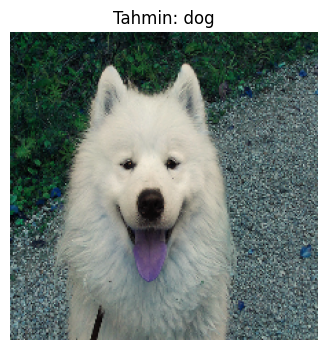

1/1 [==============================] - 0s 41ms/step


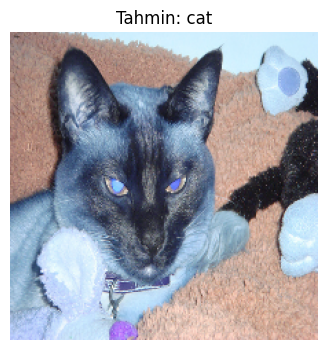

1/1 [==============================] - 0s 55ms/step


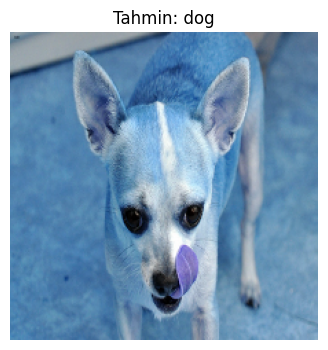

1/1 [==============================] - 0s 52ms/step


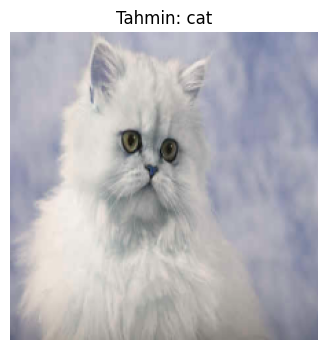

1/1 [==============================] - 0s 48ms/step


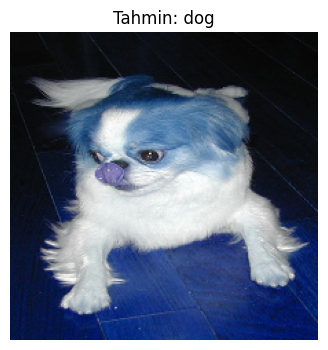

1/1 [==============================] - 0s 61ms/step


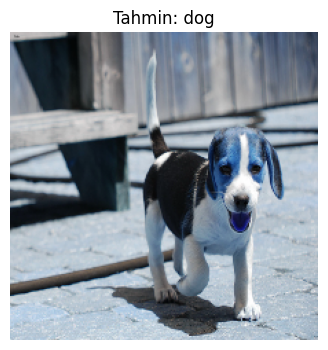

Kosinüs Benzerliği: 0.30119588971138
Öklid Mesafesi: 25.4735164642334


In [19]:
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
similarities = []

for i, img in enumerate(X_val):  
    img_with_batch = np.expand_dims(img / 255.0, axis=0)  # Normalize et ve batch boyutunu ekle
    feature = pretrained_model_without_top_layer(img_with_batch)  # Feature extraction kısmı
    feature = np.squeeze(feature)  # Fazladan boyutu kaldır
    similarities.append(feature)
    predictions = loaded_model.predict(img_with_batch)
    predicted_class = np.argmax(predictions)
    
    # Görüntüyü göster
    plt.figure(figsize=(4, 4))
    plt.imshow(img.astype("uint8"))  # Görüntüyü çizmek için uint8 formatına dönüştür
    plt.title(f"Tahmin: {class_names[predicted_class]}")
    plt.axis("off")  # Ekseni kapat
    plt.show()
    
    # İlk birkaç görüntüyü göstermek için
    if i == 5:  
        break
if len(similarities) >= 2:
    
    feature1 = similarities[0]
    feature2 = similarities[1]
    
    # Kosinüs Benzerliği
    cosine_similarity = dot(feature1, feature2) / (norm(feature1) * norm(feature2))
    print(f"Kosinüs Benzerliği: {cosine_similarity}")
    
    # Öklid Mesafesi
    euclidean_distance = norm(feature1 - feature2)
    print(f"Öklid Mesafesi: {euclidean_distance}")

In [28]:
image1_path = "C:\\Users\\samet\\Code\\pet-dataset\\training\\output\\cat\\Bengal_35.jpg"

1/1 [==============================] - 0s 48ms/step
Kosinüs Benzerliği: %66.30
Öklid Mesafesi: 18.5162


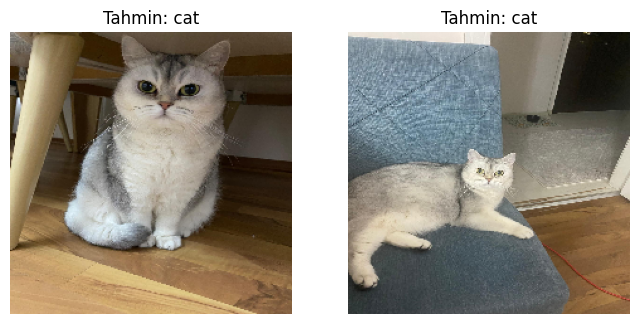

In [20]:
from tensorflow.keras.utils import load_img, img_to_array
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))  
    image_array = img_to_array(image) / 255.0  
    image_with_batch = np.expand_dims(image_array, axis=0)  
    return image_with_batch

# Özellik çıkarma fonksiyonu
def extract_features(image_path, model):
    image_with_batch = preprocess_image(image_path)
    features = model(image_with_batch)  
    return np.squeeze(features)  
#"C:\Users\samet\Downloads\WhatsApp Image 2025-03-20 at 13.54.21 (2).jpeg"
# Görsellerin dosya yolları
image1_path = "C:\\Users\\samet\\OneDrive\\Resimler\\evcil\\WhatsApp Image 2025-03-21 at 20.33.39.jpeg"
image2_path = "C:\\Users\\samet\\OneDrive\\Resimler\\evcil\\WhatsApp Image 2025-03-21 at 20.33.40 (1).jpeg"
#basset_hound_66.jpg
#beagle_121.jpg

#Ragdoll_170.jpg
# Özellik vektörlerini çıkar
feature1 = extract_features(image1_path, pretrained_model_without_top_layer)
feature2 = extract_features(image2_path, pretrained_model_without_top_layer)

# Kosinüs Benzerliği Hesaplama
cosine_similarity = np.dot(feature1, feature2) / (norm(feature1) * norm(feature2))
cosine_similarity_percentage = cosine_similarity * 100

# Öklid Mesafesi Hesaplama
euclidean_distance = np.linalg.norm(feature1 - feature2)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
img1 = load_img(image1_path, target_size=(224, 224))
img2 = load_img(image2_path, target_size=(224, 224))

axes[0].imshow(img1)
axes[0].axis("off")
img1_batch = preprocess_image(image1_path)
predictions = loaded_model.predict(img1_batch)
predicted_class1 = np.argmax(predictions)
axes[0].set_title(f"Tahmin: {class_names[predicted_class1]}")

axes[1].imshow(img2)
axes[1].axis("off")
img2_batch = preprocess_image(image2_path)
predictions = loaded_model.predict(img2_batch)
predicted_class2 = np.argmax(predictions)
axes[1].set_title(f"Tahmin: {class_names[predicted_class2]}")
# Sonuçları yazdır
print(f"Kosinüs Benzerliği: %{cosine_similarity_percentage:.2f}")
print(f"Öklid Mesafesi: {euclidean_distance:.4f}")

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

# Özel katmanı belirt
custom_objects = {'KerasLayer': hub.KerasLayer}

# Modeli özel katmanlarla yükle
model = tf_keras.models.load_model("my_newModel.h5", custom_objects=custom_objects)

# TFLite dönüşümü
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Modeli kaydet
with open("model.tflite", "wb") as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\samet\AppData\Local\Temp\tmp2t4uben7\assets


INFO:tensorflow:Assets written to: C:\Users\samet\AppData\Local\Temp\tmp2t4uben7\assets


In [11]:
import tensorflow as tf
import tensorflow_hub as hub

# MobileNetV2'nin özellik çıkarıcı modelini oluştur
feature_extractor = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                                   input_shape=(224, 224, 3), trainable=False)

model = tf_keras.Sequential([
    feature_extractor  # Dense katman eklemiyoruz, sadece özellik çıkarma yapacak
])

# Modeli kaydet
model.save("feature_extraction_model.h5")

# TFLite formatına dönüştür
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# TFLite modelini kaydet
with open("feature_extraction_model.tflite", "wb") as f:
    f.write(tflite_model)


C:\Users\samet\AppData\Local\Programs\Python\Python311\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\samet\AppData\Local\Temp\tmpi22cto8p\assets


INFO:tensorflow:Assets written to: C:\Users\samet\AppData\Local\Temp\tmpi22cto8p\assets


In [21]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model

# Triplet Loss Fonksiyonu
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[:, :128], y_pred[:, 128:256], y_pred[:, 256:]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
    return loss

# MobileNetV2 Feature Extractor
feature_extractor_model = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/tf2-preview-feature-vector/4"
pretrained_model = hub.KerasLayer(feature_extractor_model, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), trainable=False, output_shape=(1280,))

# Temel Model (Feature Extractor + Dropout + Embedding)
inputs = layers.Input(shape=(224, 224, 3))
features = layers.Lambda(lambda x: pretrained_model(x))(inputs)
dropout = layers.Dropout(0.5, name='dropout')(features)
embedding = layers.Dense(128, activation='relu', name='embedding')(dropout)
feature_model = Model(inputs, embedding)  # Feature extractor’dan embedding’e kadar

# Base Model (Sınıflandırma)
classification_output = layers.Dense(1, activation='sigmoid', name='classification')(embedding)
base_model = Model(inputs, classification_output)

# Triplet Modeli
input_anchor = layers.Input(shape=(224, 224, 3))
input_positive = layers.Input(shape=(224, 224, 3))
input_negative = layers.Input(shape=(224, 224, 3))

# Feature Model ile embedding’leri çıkar
embedding_anchor = feature_model(input_anchor)
embedding_positive = feature_model(input_positive)
embedding_negative = feature_model(input_negative)

triplet_output = layers.Concatenate()([embedding_anchor, embedding_positive, embedding_negative])
triplet_model = Model([input_anchor, input_positive, input_negative], triplet_output)

triplet_model.compile(optimizer='adam', loss=triplet_loss)
base_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Tek çıktı için
    metrics=['accuracy']
)

base_model.summary()
triplet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Dense)                    │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,097 (641.00 KB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ (None, 128)               │         163,968 │ input_layer_1[0][0],       │
│                               │                           │                 │ input_layer_2[0][0],       │
│                               │                           │                 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 384)               │               0 │ functional[0][0],          │
│                               │                           │                 │ functional[1][0],          │
│                               │                           │                 │ functional[2][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 163,968 (640.50 KB)

 Trainable params: 163,968 (640.50 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
import tensorflow as tf
import numpy as np

# Triplet Generator Fonksiyonu
def generate_triplets(X, y, batch_size=32):
    def gen():
        while True:
            anchor_images = []
            positive_images = []
            negative_images = []
            
            for _ in range(batch_size):
                anchor_idx = np.random.randint(0, len(X))
                anchor_label = y[anchor_idx]
                
                positive_indices = np.where(y == anchor_label)[0]
                positive_idx = np.random.choice(positive_indices)
                
                negative_indices = np.where(y != anchor_label)[0]
                negative_idx = np.random.choice(negative_indices)
                
                anchor_images.append(X[anchor_idx])
                positive_images.append(X[positive_idx])
                negative_images.append(X[negative_idx])
            
            yield (
                (
                    np.array(anchor_images, dtype=np.float32),
                    np.array(positive_images, dtype=np.float32),
                    np.array(negative_images, dtype=np.float32)
                ),
                np.zeros((batch_size,), dtype=np.float32)  # Dummy targets
            )
    
    # Çıktı türlerini ve şekillerini tanımla
    output_signature = (
        (
            tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),  # Anchor
            tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),  # Positive
            tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32)   # Negative
        ),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)  # Dummy targets
    )
    
    return tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature
    )

# Generator’ı oluştur
BATCH_SIZE = 32
triplet_dataset = generate_triplets(X_train_scaled, y_train, batch_size=BATCH_SIZE)


In [23]:
# Triplet Modelini Eğitme
steps_per_epoch = len(X_train_scaled) // BATCH_SIZE
triplet_model.fit(triplet_dataset, steps_per_epoch=steps_per_epoch, epochs=1)


161/161 ━━━━━━━━━━━━━━━━━━━━ 85s 506ms/step - loss: 2.6199 


In [24]:
# Sınıflandırma Modelini Eğitme 
base_model.fit(
    train_generator,  # Hedef veriler generator içinde
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=len(X_val_scaled) // BATCH_SIZE,
    epochs=1
)

C:\Users\samet\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 94s 568ms/step - accuracy: 0.9487 - loss: 0.1603 - val_accuracy: 0.9881 - val_loss: 0.0315


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


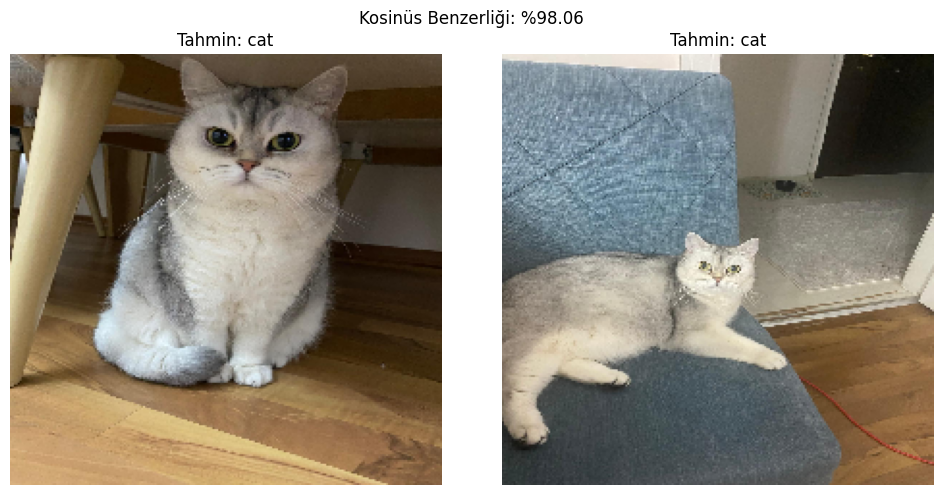

Görsel 1: C:\Users\samet\OneDrive\Resimler\evcil\WhatsApp Image 2025-03-21 at 20.33.39.jpeg
Tahmin: cat
Görsel 2: C:\Users\samet\OneDrive\Resimler\evcil\WhatsApp Image 2025-03-21 at 20.33.40 (1).jpeg
Tahmin: cat
Kosinüs Benzerliği: %98.06


In [80]:
from scipy.spatial.distance import cosine

# 2 Görselin Path’leri
image1_path = "C:\\Users\\samet\\OneDrive\\Resimler\\evcil\\WhatsApp Image 2025-03-21 at 20.33.39.jpeg"
image2_path = "C:\\Users\\samet\\OneDrive\\Resimler\\evcil\\WhatsApp Image 2025-03-21 at 20.33.40 (1).jpeg"
#"C:\Users\samet\OneDrive\Resimler\evcil\WhatsApp Image 2025-03-21 at 20.33.39 (1).jpeg"
# Özellik vektörlerini çıkar
feature1 = extract_features(image1_path, feature_model)
feature2 = extract_features(image2_path, feature_model)

# Kosinüs Benzerliği Hesaplama
cosine_similarity = 1 - cosine(feature1.flatten(), feature2.flatten())  # 1 - cosine mesafesi = benzerlik
cosine_similarity_percentage = cosine_similarity * 100

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# İlk görsel
img1 = load_img(image1_path, target_size=(224, 224))
axes[0].imshow(img1)
axes[0].axis("off")
img1_batch = preprocess_image(image1_path)
predictions1 = base_model.predict(img1_batch)
predicted_class1 = np.argmax(predictions1)
axes[0].set_title(f"Tahmin: {class_names[predicted_class1]}")

# İkinci görsel
img2 = load_img(image2_path, target_size=(224, 224))
axes[1].imshow(img2)
axes[1].axis("off")
img2_batch = preprocess_image(image2_path)
predictions2 = base_model.predict(img2_batch)
predicted_class2 = np.argmax(predictions2)
axes[1].set_title(f"Tahmin: {class_names[predicted_class2]}")

plt.suptitle(f"Kosinüs Benzerliği: %{cosine_similarity_percentage:.2f}")
plt.tight_layout()
plt.show()

# Sonuçları yazdır
print(f"Görsel 1: {image1_path}")
print(f"Tahmin: {class_names[predicted_class1]}")
print(f"Görsel 2: {image2_path}")
print(f"Tahmin: {class_names[predicted_class2]}")
print(f"Kosinüs Benzerliği: %{cosine_similarity_percentage:.2f}")

In [72]:
# 3. Modelleri Kaydetme
feature_model.save("feature_model.h5")
base_model.save("base_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Veritabanı embedding’leri ve path’ler kaydedildi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Test Görseli Tahmini: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


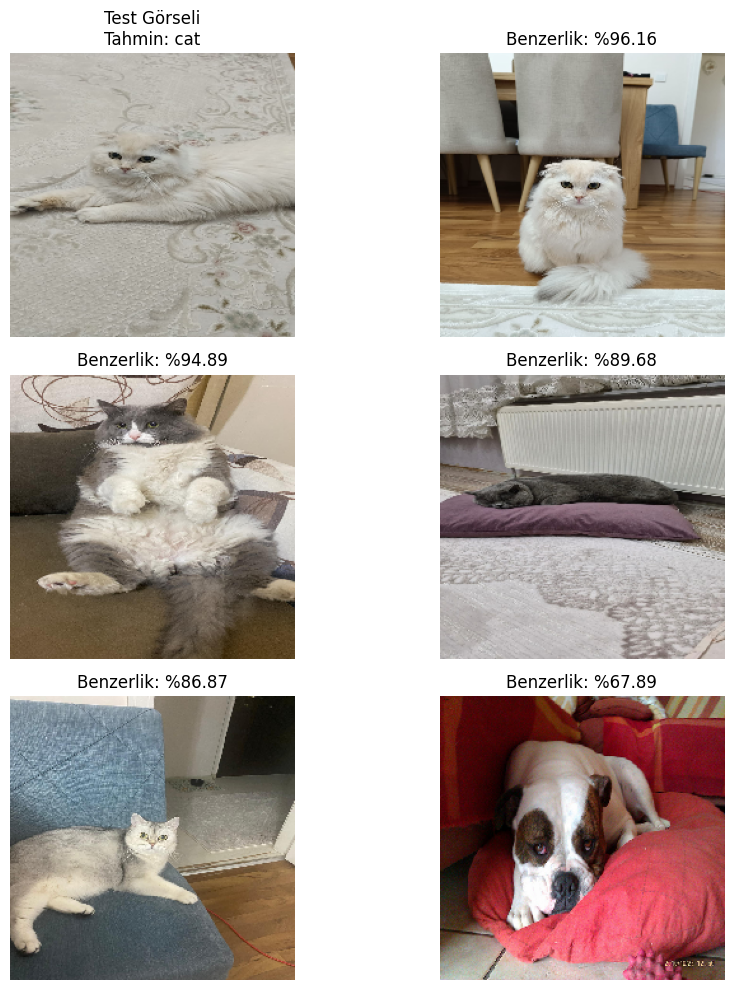


Test Görseli ile En Benzer 3 Görsel:
Görsel: C:\Users\samet\OneDrive\Resimler\evcil\WhatsApp Image 2025-03-21 at 20.33.39 (1).jpeg, Benzerlik: %96.16
Görsel: C:\Users\samet\OneDrive\Resimler\evcil\WhatsApp Image 2025-03-20 at 13.54.21.jpeg, Benzerlik: %94.89
Görsel: C:\Users\samet\OneDrive\Resimler\evcil\WhatsApp Image 2025-03-21 at 20.35.45.jpeg, Benzerlik: %89.68
Görsel: C:\Users\samet\OneDrive\Resimler\evcil\WhatsApp Image 2025-03-21 at 20.33.40 (1).jpeg, Benzerlik: %86.87
Görsel: C:\Users\samet\Code\pet-dataset\training\output\dog\american_bulldog_6.jpg, Benzerlik: %67.89


In [47]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import json
import os

# Sabitler (önceki kodlardan varsayıyorum)
IMAGE_SIZE = 224
class_names = ['cat', 'dog']  # Sınıf isimleri (önceki kodlara göre)

# Önceden tanımlı fonksiyonlar (tekrar yazmıyorum, varsayıyorum ki mevcut)
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Görsel bulunamadı: {image_path}")
    image = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image_array = img_to_array(image) / 255.0
    image_with_batch = np.expand_dims(image_array, axis=0)
    return image_with_batch

def extract_features(image_path, model):
    image_with_batch = preprocess_image(image_path)
    features = model.predict(image_with_batch)
    return np.squeeze(features)




# 4. Veritabanı Embedding’lerini Hazırlama
database_image_paths = [
    "C:\\Users\\samet\\OneDrive\\Resimler\\evcil\\WhatsApp Image 2025-03-21 at 20.33.39 (1).jpeg",
    "C:\\Users\\samet\\OneDrive\\Resimler\\evcil\\WhatsApp Image 2025-03-20 at 13.54.21.jpeg",
    "C:\\Users\\samet\\OneDrive\\Resimler\\evcil\\WhatsApp Image 2025-03-21 at 20.35.45.jpeg",
    "C:\\Users\\samet\\Code\\pet-dataset\\training\\output\\dog\\american_bulldog_6.jpg",
    "C:\\Users\\samet\\OneDrive\\Resimler\\evcil\\WhatsApp Image 2025-03-21 at 20.33.40 (1).jpeg"
]
# "C:\\Users\\samet\\Code\\pet-dataset\\training\\output\\cat\\Bengal_35.jpg"
database_embeddings = []
for path in database_image_paths:
    if os.path.exists(path):  # Dosyanın varlığını kontrol et
        embedding = extract_features(path, feature_model)
        database_embeddings.append(embedding)
    else:
        print(f"Dosya bulunamadı: {path}")

database_embeddings = np.array(database_embeddings)
np.save("database_embeddings.npy", database_embeddings)
with open("database_image_paths.json", "w") as f:
    json.dump(database_image_paths, f)
print("Veritabanı embedding’leri ve path’ler kaydedildi.")

# 5. Test Görselini İşleme
test_image_path = "C:\\Users\\samet\\OneDrive\\Resimler\\evcil\\WhatsApp Image 2025-03-21 at 20.33.39 (2).jpeg"

# Sınıflandırma tahmini
test_image_batch = preprocess_image(test_image_path)
predictions = base_model.predict(test_image_batch)
predicted_class = np.argmax(predictions)
print(f"Test Görseli Tahmini: {class_names[predicted_class]}")

# Test görselinin embedding’ini çıkar
test_embedding = extract_features(test_image_path, feature_model)

# Veritabanı embedding’lerini yükle
database_embeddings = np.load("database_embeddings.npy")
with open("database_image_paths.json", "r") as f:
    database_image_paths = json.load(f)

# Benzerlikleri hesapla ve sırala
similarities = []
for i, db_embedding in enumerate(database_embeddings):
    similarity = 1 - cosine(test_embedding.flatten(), db_embedding.flatten())
    similarities.append((similarity, i))

similarities.sort(reverse=True)
top_3_matches = similarities[:5]

# 6. Sonuçları Görselleştirme
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Test görseli
test_img = load_img(test_image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
axes[0, 0].imshow(test_img)
axes[0, 0].axis("off")
axes[0, 0].set_title(f"Test Görseli\nTahmin: {class_names[predicted_class]}")

# En benzer 3 görsel
for i, (similarity, idx) in enumerate(top_3_matches):
    img = load_img(database_image_paths[idx], target_size=(IMAGE_SIZE, IMAGE_SIZE))
    row, col = (i + 1) // 2, (i + 1) % 2
    axes[row, col].imshow(img)
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Benzerlik: %{similarity*100:.2f}")

plt.tight_layout()
plt.show()

# Sonuçları yazdır
print("\nTest Görseli ile En Benzer 3 Görsel:")
for similarity, idx in top_3_matches:
    print(f"Görsel: {database_image_paths[idx]}, Benzerlik: %{similarity*100:.2f}")

In [26]:
print(tf.__version__)

2.18.0
